# **Demographic Impact on Mental Health Conditions**

## Analysis Based On Technology Sectors Employee  Survey

## INTRODUCTION

The analysis goal is to understand how mental health conditions are distributed across different demographic groups and to uncover any patterns or trends between demographic factors (such as age, gender, country, or state) and reported mental conditions.

Key questions I will try to answer :

What percentage of individuals working in the technology sector experience mental health issues?

What are the most common mental conditions?

Which age groups are most prone to being diagnosed with such conditions?

Is there a link between location (country, state) and the mental conditions reported?

How do mental health conditions vary across different gender groups, and which conditions are most commonly reported by each gender?


Answering these questions can provide insights into which groups might need targeted mental health interventions.

Importing libraries :

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import geopandas as gpd
import statsmodels.stats.proportion as smp

from mpl_toolkits.axes_grid1 import make_axes_locatable
from typing import Dict, Optional, Any

from MentalHealthCustomFunctionsDictionaries import (
    filter_unrealistic_ages,
    question_mapping,
    gender_mapping,
    country_mapping,
    condition_mapping,
    plot_age_boxplot,
    plot_age_distribution_2016,
    plot_gender_distribution_2016,
    categorize_condition,
    generate_age_conditions_contingency_heatmap_2016,
    generate_normalized_age_conditions_heatmap_2016,
    plot_answers_by_year,
    unique_questions_per_year,
    plot_unique_respondents_by_year,
    count_unique_genders_2016,
    count_men_conditions_2016,
    count_women_conditions_2016,
    count_other_gender_conditions_2016,
    plot_multibar_conditions_2016,
    plot_multibar_conditions_percentage_2016,
    plot_us_state_distribution_map_2016,
    plot_global_country_distribution_2016,
    plot_condition_breakdown_2016_horizontal,
    plot_mental_health_conditions_with_CI_2016,
    rank_top_20_categorized_conditions_2016,
    rank_top_20_conditions_across_states_2016,
    get_state_data,
)

Defining the database :

In [2]:
db_path = "mental_health.sqlite"

Establishing a connection to a SQLite database and creating a cursor object to interact with it. The cursor is like a handle that you use to execute SQL queries and fetch results from the database :

In [3]:
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

Using a context manager to automatically close the connection. When the code block within the with statement will be exited, the connection will be automatically closed, even if the errors occur :

In [4]:
with sqlite3.connect(db_path) as conn:
    cursor = conn.cursor()

## DATA CLEANING

Fetching all table names :

In [5]:
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
table_names = [table[0] for table in tables]
print("Tables in database:", table_names)

Tables in database: ['Answer', 'Question', 'Survey']


Previewing each table's schema (PRAGMA table_info (table_name) - retrieves metadata about a table, including information about its columns) :

In [6]:
for table in table_names:
    print(f"\nSchema of {table}:")
    cursor.execute(f"PRAGMA table_info({table});")
    schema = cursor.fetchall()
    for column in schema:
        print(column)


Schema of Answer:
(0, 'AnswerText', 'VARCHAR(10000)', 0, None, 0)
(1, 'SurveyID', 'INTEGER', 0, None, 0)
(2, 'UserID', 'INTEGER', 0, None, 0)
(3, 'QuestionID', 'INTEGER', 0, None, 0)

Schema of Question:
(0, 'questiontext', 'VARCHAR(1000)', 0, None, 0)
(1, 'questionid', 'INTEGER', 0, None, 0)

Schema of Survey:
(0, 'SurveyID', 'INTEGER', 1, None, 1)
(1, 'Description', 'VARCHAR(255)', 0, None, 0)


Reading the data from three different tables in a SQLite database and loading them into the pandas :

In [7]:
answer_df = pd.read_sql("SELECT * FROM Answer", conn)
question_df = pd.read_sql("SELECT * FROM Question", conn)
survey_df = pd.read_sql("SELECT * FROM Survey", conn)

Merging tables to create a full dataset. This combines related data, makes it easier to analyze and understand it :

In [8]:
merged_df = answer_df.merge(
    question_df, left_on="QuestionID", right_on="questionid", how="left"
).merge(survey_df, on="SurveyID", how="left")

Standardizing and grouping similar questions across survey years. This is a crucial step in data cleaning and preparation, especially when dealing with survey data where questions might be phrased differently but essentially ask the same thing. It also gives more data consistency and code readibility (using dictionary from a supportive file) :

In [9]:
merged_df["questiontext"] = merged_df["questiontext"].replace(question_mapping)

Dealing with missing data. Filling any missing values (NaN) in the AnswerText column of merged_df with the string "Not Provided" :

In [10]:
merged_df["AnswerText"] = merged_df["AnswerText"].fillna("Not Provided")

Converting age to numeric. This is a crucial step to ensure performing numerical operations on the age data.:

In [11]:
merged_df.loc[merged_df["questiontext"] == "Age", "AnswerText"] = pd.to_numeric(
    merged_df.loc[merged_df["questiontext"] == "Age", "AnswerText"], errors="coerce"
)

Taking a closer look at the age outliers with box plot (function from a supportive file): 

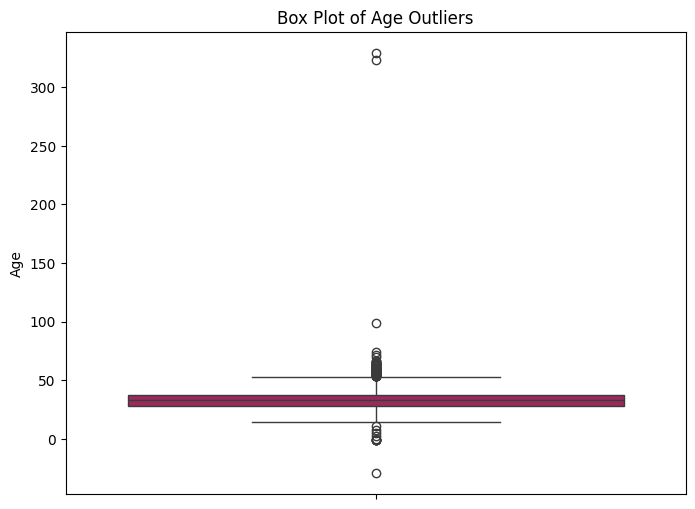

In [12]:
plot_age_boxplot(merged_df)

It seems that there's some unrealistic ages like the one's above 100 and below 0 we should remove them.

Converting 'AnswerText' related to age to a numeric (Without errors="coerce", pd.to_numeric() would raise a ValueError). The code snippet extracts the "AnswerText" values related to "Age", attempts to convert them to numbers, and replaces any non-convertible values with NaN.  The result is stored in temp_age_numeric :

In [13]:
temp_age_numeric = pd.to_numeric(
    merged_df.loc[merged_df["questiontext"] == "Age", "AnswerText"], errors="coerce"
)

Detecting and replacing outliers, ensuring negative ages and unrealistically old ages are handled. Using function filter_unrealistic_ages that filters out unlikely age values from a Pandas Series, replacing them with NaN :

In [14]:
temp_age_numeric_cleaned = filter_unrealistic_ages(
    temp_age_numeric, min_age=0, max_age=100
)
merged_df.loc[merged_df["questiontext"] == "Age", "AnswerText"] = (
    temp_age_numeric_cleaned.fillna("Not Provided")
)

Isolating the age data, removing missing values :

In [15]:
age_series = merged_df.loc[merged_df["questiontext"] == "Age", "AnswerText"].dropna()

Age data processing and categorization :
1. Converts the age_series to numeric (errors="coerce" forces any non-numeric values to become NaN). Removes any NaN values that might have resulted from the previous conversion, ensuring only numbers should be staying.
2. Creating "Age group" column in the age_series after all cleaning and processing. Two lists with labels and bins are created as well. Bins defines age ranges groups.
3. Checking unique values.

In [16]:
age_series = pd.to_numeric(age_series, errors="coerce").dropna()

if not age_series.empty:
    merged_df.loc[merged_df["questiontext"] == "Age", "Age Group"] = pd.cut(
        age_series,
        bins=[0, 19, 29, 39, 49, 59, 100],
        labels=["<20", "20-29", "30-39", "40-49", "50-59", "60+"],
        right=False,
    )
else:
    merged_df.loc[merged_df["questiontext"] == "Age", "Age Group"] = "Not Provided"

print(age_series.unique())

[37. 44. 32. 31. 33. 35. 39. 42. 23. 29. 36. 27. 46. 41. 34. 30. 40. 38.
 50. 24. 18. 28. 26. 22. 19. 25. 45. 21. 43. 56. 60. 54. 55. 48. 20. 57.
 58. 47. 62. 51. 65. 49.  5. 53. 61.  8. 11. 72. 52. 17. 63. 99.  3. 66.
 59. 15. 74. 70. 64. 67.  0.]


Checking the situation with genders :

In [17]:
raw_genders = merged_df.loc[merged_df["questiontext"] == "Gender", "AnswerText"]
print("Raw Unique Genders Before Mapping:", raw_genders.unique())

Raw Unique Genders Before Mapping: ['Female' 'Male' 'Male-ish' 'Trans-female' 'something kinda male?'
 'queer/she/they' 'non-binary' 'Nah' 'All' 'Enby' 'fluid' 'Genderqueer'
 'Androgyne' 'Agender' 'Guy (-ish) ^_^' 'male leaning androgynous'
 'Trans woman' 'Neuter' 'Female (trans)' 'queer' 'A little about you' 'p'
 'ostensibly male, unsure what that really means' 'Bigender'
 'Female assigned at birth' 'fm' 'Transitioned, M2F'
 'Genderfluid (born female)' 'Other/Transfeminine'
 'Female or Multi-Gender Femme' 'Androgynous' 'male 9:1 female, roughly'
 '-1' 'Other' 'nb masculine' 'none of your business' 'genderqueer' 'Human'
 'Genderfluid' 'genderqueer woman' 'mtf' 'Queer' 'Fluid'
 'Male/genderqueer' 'Nonbinary' 'human' 'Unicorn' 'Male (trans, FtM)'
 'Genderflux demi-girl' 'female-bodied; no feelings about gender' 'AFAB'
 'Transgender woman' 'male' 'female' 'male/androgynous'
 'uhhhhhhhhh fem genderqueer?' 'God King of the Valajar' 'Non-binary'
 'Agender/genderfluid' 'sometimes' 'Woman-iden

Gender mapping, standardizing gender responses. Code addresses potential inconsistencies in how people might input their gender, ensuring uniformity for analysis (using dictionary from a supportive file) :

In [18]:
if "Gender" in merged_df["questiontext"].values:

    merged_df.loc[merged_df["questiontext"] == "Gender", "AnswerText"] = (
        merged_df.loc[merged_df["questiontext"] == "Gender", "AnswerText"]
        .astype(str)
        .str.strip()
        .str.title()
        .replace(gender_mapping)
    )

    merged_df = merged_df[
        (merged_df["questiontext"] != "-1") & (merged_df["AnswerText"] != "-1")
    ]

    valid_genders = ["Male", "Female", "Other"]
    merged_df.loc[merged_df["questiontext"] == "Gender", "AnswerText"] = merged_df.loc[
        merged_df["questiontext"] == "Gender", "AnswerText"
    ].apply(lambda x: x if x in valid_genders else "Other")

print(
    "Unique Genders after fixing:",
    merged_df.loc[merged_df["questiontext"] == "Gender", "AnswerText"].unique(),
)

Unique Genders after fixing: ['Female' 'Male' 'Other']


Standardizing country names for better data consistency. As well there's countries with the same name like United States and United States of America, we have to take care of that using country_mapping dictionary and replace function :


In [19]:
merged_df.loc[merged_df["questiontext"] == "Country", "AnswerText"] = (
    merged_df.loc[merged_df["questiontext"] == "Country", "AnswerText"]
    .str.strip()
    .str.title()
)

merged_df.loc[merged_df["questiontext"] == "Country", "AnswerText"] = merged_df.loc[
    merged_df["questiontext"] == "Country", "AnswerText"
].replace(country_mapping)

 Printing cleaned dataset :

The data on states are not clean, I will have to custom get_state_data function to properly manage it : 

In [20]:
state_data = get_state_data(db_path)

print(state_data.head())

        state  respondent_count
0  California               382
1    Illinois               223
2  Washington               168
3    New York               146
4   Tennessee               121


## General overview of the survey and timeline

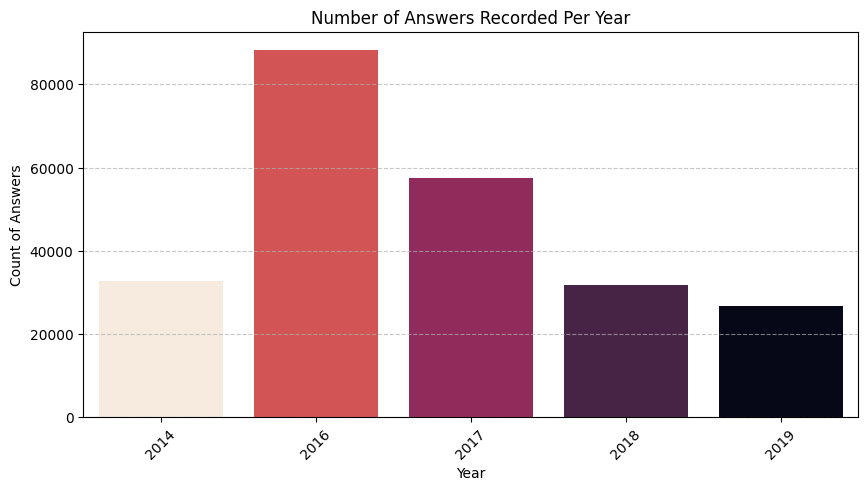

,Year,AnswerCount
0,2014,32760
1,2016,88238
2,2017,57456
3,2018,31692
4,2019,26752


In [21]:
(plot_answers_by_year)(db_path)

The data shows the decline in answer count since 2016 and missing answer data from 2015, indicating that survey wasn't active during 2015 period.

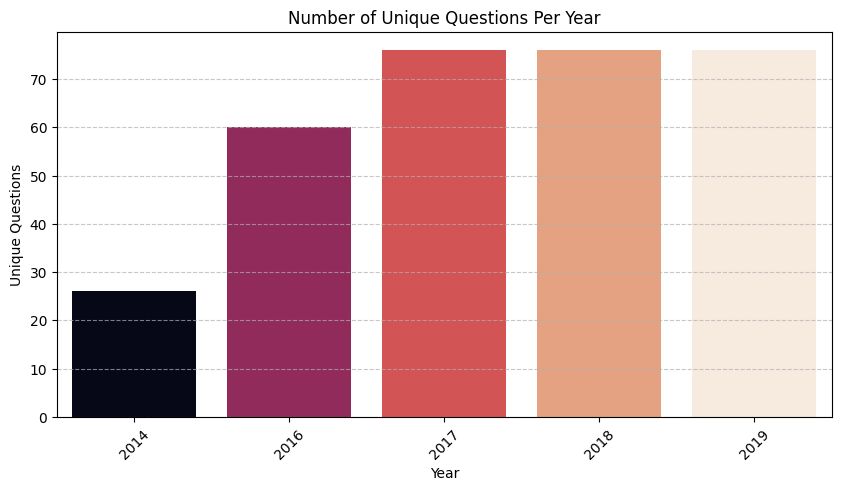

,Year,UniqueQuestions
0,2014,26
1,2016,60
2,2017,76
3,2018,76
4,2019,76


In [22]:
unique_questions_per_year(db_path)

Number of questions through out the years grew reaching 76 unique question limit since 2017. It indicates that questions varies and might be different through out the years.

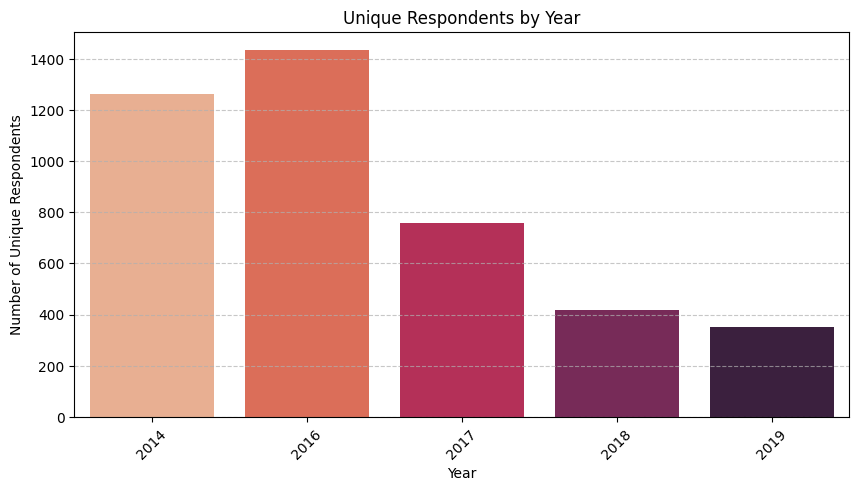

In [23]:
unique_users_by_year_df = plot_unique_respondents_by_year(db_path)

Unique respondants peaks at 2016 and gets smaller every year until the end of survey 2019. 

I am interested in one of the questions about diagnosed conditions in the survey and I want to find out :
1. What year it has been asked? Is it asked each year ?
2. Is there any similar questions ? 

In [24]:
sql_query = """
SELECT QuestionText
FROM Question
WHERE QuestionID = 115;
"""

with sqlite3.connect(db_path) as conn:
    question_115_text = pd.read_sql_query(sql_query, conn)

# Display the text of Question ID 115
question_115_text

,questiontext
0,"If yes, what condition(s) have you been diagno..."


That question is "If yes, what condition(s) have you been diagnosed with?" - If you mental condition, what conditions(s) have you been diagnosed?" and is crucial for my analysis, indicating how many people have been diagnosed with and what types of mental conditions they might have.

In [25]:
sql_query = """
SELECT DISTINCT SUBSTR(SurveyID, 1, 4) AS Year
FROM Answer
WHERE QuestionID = 115
ORDER BY Year;
"""

with sqlite3.connect(db_path) as conn:
    question_115_years = pd.read_sql_query(sql_query, conn)
    print(question_115_years)

   Year
0  2016


In [26]:
sql_query = """
SELECT DISTINCT QuestionID, QuestionText
FROM Question
WHERE LOWER(QuestionText) LIKE '%condition%' OR LOWER(QuestionText) LIKE '%mental health%' 
   OR LOWER(QuestionText) LIKE '%diagnosed%' OR LOWER(QuestionText) LIKE '%disorder%'
ORDER BY QuestionID;
"""

with sqlite3.connect(db_path) as conn:
    similar_questions = pd.read_sql_query(sql_query, conn)
    print(similar_questions)

    questionid                                       questiontext
0            7  Have you ever sought treatment for a mental he...
1           10  Does your employer provide mental health benef...
2           11  Is your anonymity protected if you choose to t...
3           12  Would you bring up a mental health issue with ...
4           14  Do you know the options for mental health care...
..         ...                                                ...
71         112  Did you hear of or observe negative consequenc...
72         113  Do you feel that being identified as a person ...
73         114  Do you think that team members/co-workers woul...
74         115  If yes, what condition(s) have you been diagno...
75         116  If maybe, what condition(s) do you believe you...

[76 rows x 2 columns]


Seems that this question is unique and only asked in 2016.

## Overview on Main Mental Conditions and Their Prevelance

Understanding the prevalence of diagnosed mental health conditions helps identify the most common disorders among respondents. This analysis focuses on self-reported mental health diagnoses based on Question 115, where participants specify their diagnosed conditions.

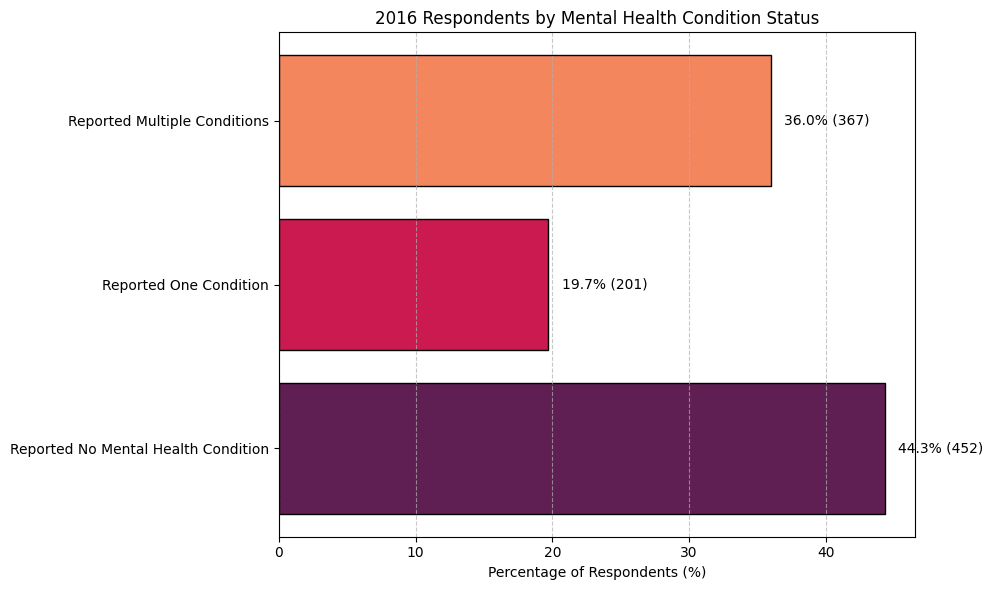

,Group,Count,Percentage
0,Reported Multiple Conditions,367,36.0%
1,Reported One Condition,201,19.7%
2,Reported No Mental Health Condition,452,44.3%


In [27]:
plot_condition_breakdown_2016_horizontal(db_path, condition_mapping)

44.3% of respondents did not report any mental health condition.

65.7% of respondents did report at least one mental health condition.

36.0% of respondents reported multiple conditions, showing a notable prevalence of comorbid conditions.

19.7% reported only one condition, indicating that a significant portion of the survey population faces single diagnoses.

The bar chart below shows the prevalence of diagnosed mental health conditions, categorized into major disorder types:

Anxiety Disorders - Includes Generalized Anxiety, Social Anxiety, Phobias

Depression - Includes Mood Disorders & Clinical Depression

OCD (Obsessive-Compulsive Disorder)

PTSD (Post-Traumatic Stress Disorder)

Eating Disorders - Includes Anorexia & Bulimia

Stress Disorders - Includes Stress Response Syndromes

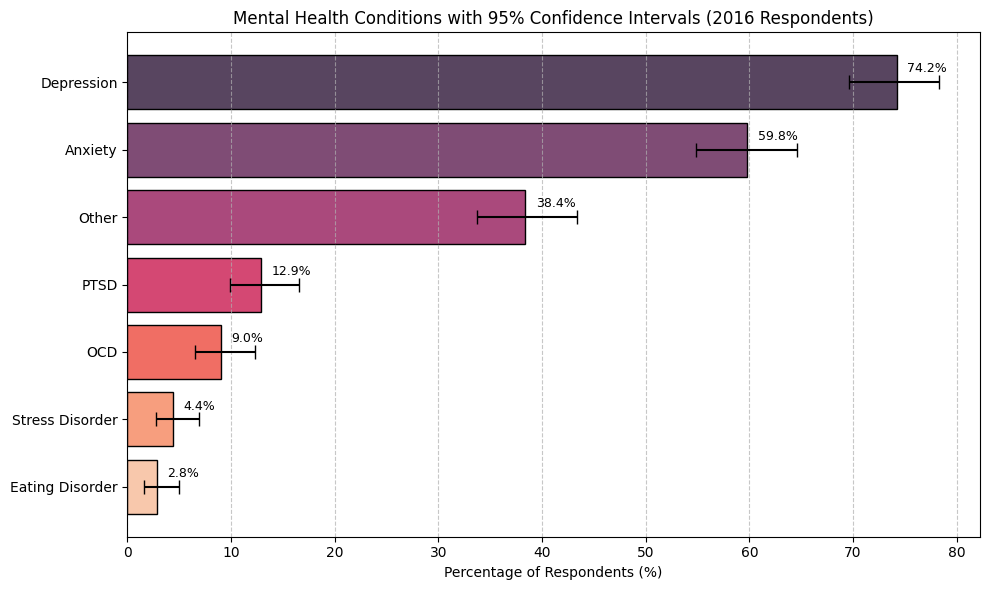

,Category,TotalUsers,Percentage,CI Lower,CI Upper
0,Eating Disorder,11,2.835052,1.590283,5.004593
1,Stress Disorder,17,4.381443,2.753289,6.904050
2,OCD,35,9.020619,6.557557,12.287172
3,PTSD,50,12.886598,9.913099,16.587787
4,Other,149,38.402062,33.698790,43.332737
5,Anxiety,232,59.793814,54.842094,64.553506
6,Depression,288,74.226804,69.652093,78.326495


In [28]:
plot_mental_health_conditions_with_CI_2016(db_path, condition_mapping)

Key insights:

Depression is the most prevalent condition, reported by 74.2% of respondents, with a confidence interval between 69.7% and 78.3%.

Anxiety is the second most common, affecting 59.8% of respondents.

38.4% of respondents reported conditions categorized as Other, which includes various additional diagnoses not specified in primary categories.

Less prevalent conditions like PTSD, OCD, Stress Disorders, and Eating Disorders show significantly lower rates, with Eating Disorders reported by only 2.8% of respondents.

Of all the respondents who reported having any diagnosed mental health condition,
74% of them reported Depression as one of their conditions.

Analysis highlights :

48.6% of all respondents in the 2016 survey reported Depression as one of their conditions.

39.3% of all respondents in the 2016 survey reported Anxiety as one of their condition.

##  Demographic Distribution    

The bar chart categorizes respondents into six age groups:

<20 (Younger respondents)
20-29 (Early-career professionals or students)
30-39 (Mid-career professionals)
40-49 (Experienced professionals)
50-59 (Late-career professionals)
60+ (Retired or senior professionals)

Visualizing results with a bar chart :

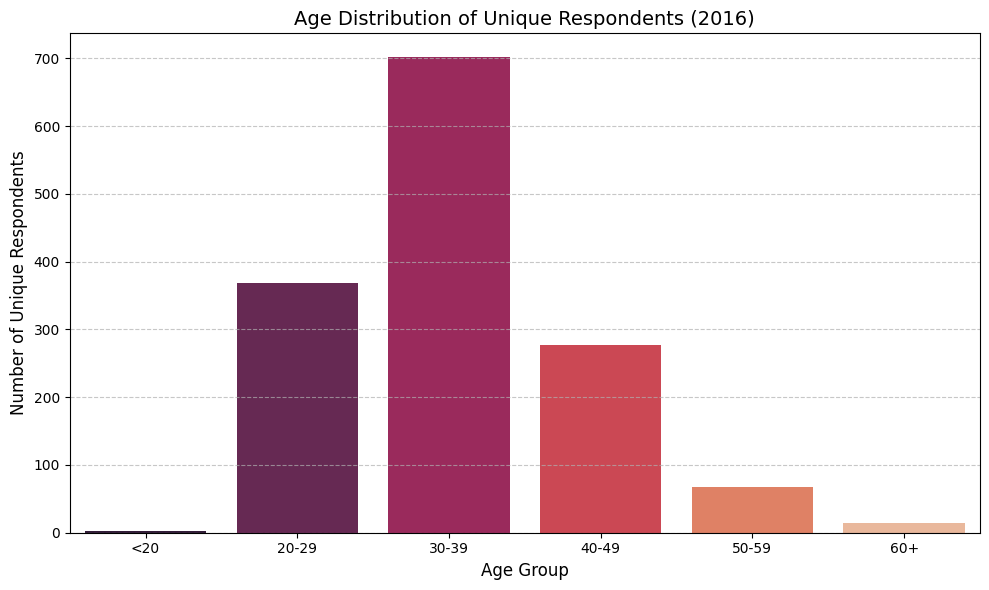

Age Group
<20        3
20-29    368
30-39    702
40-49    277
50-59     68
60+       14
Name: count, dtype: int64


In [ ]:
age_distribution_2016 = plot_age_distribution_2016(merged_df)

print(age_distribution_2016)

The 30-39 age group has the highest participation, reflecting mid-career individuals who may have a vested interest in workplace or mental health discussions.
The 20-29 age group also shows strong participation, likely representing early-career professionals and students who are more engaged in digital platforms and surveys.
Respondents above 50 years old are significantly fewer, which could indicate lower survey reach among older demographics or less willingness to participate.

Visualizing the data :

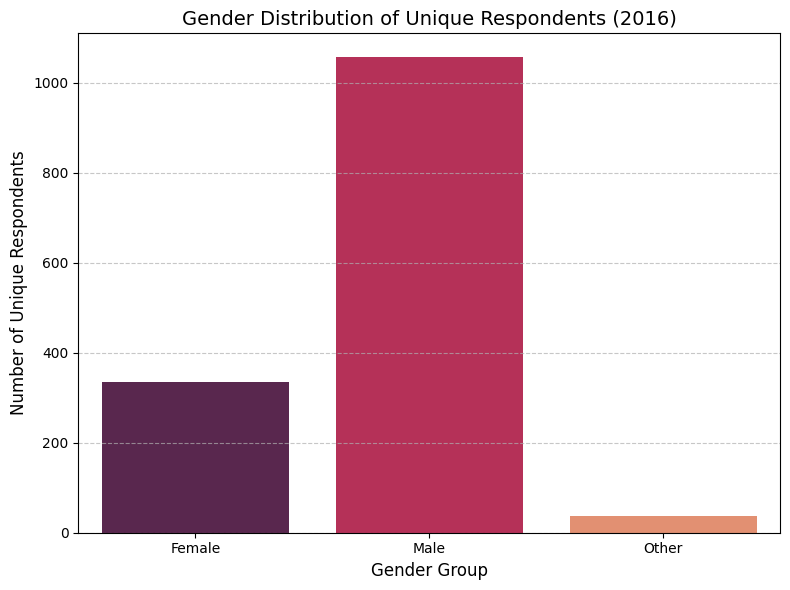

Gender Group
Female     336
Male      1057
Other       37
Name: count, dtype: int64

In [45]:
plot_gender_distribution_2016(merged_df)

The ratio of Male to Female respondents is approximately 3.14:1 (1,057 males to 336 females), indicating a significantly larger representation of males in the dataset.
The ratio of Male to Other gender respondents is about 28.57:1 (1,057 males to 37 others), which highlights a much smaller representation of individuals who identify outside the traditional gender categories.
The ratio of Female to Other gender respondents is approximately 9.08:1 (336 females to 37 others), showing a greater proportion of females compared to individuals in the "Other" gender category.

What is the geographic distribution of respondents?

The geographic distribution of survey respondents provides a view of regional engagement, but it may also reflect external factors influencing participation.

Key Considerations:

Tech Industry Presence: Higher response rates in certain regions may correlate with tech sector development rather than overall engagement. Areas with a strong technology workforce likely have higher survey visibility.

Survey Outreach Bias: Some regions may show higher participation due to targeted outreach efforts. If the survey was shared more actively in specific countries or states, the data might reflect where respondents were most likely to be reached rather than genuine interest differences.

Language & Accessibility: Lower participation in some regions could be due to language barriers or lack of familiarity with the survey platform, affecting overall representation.

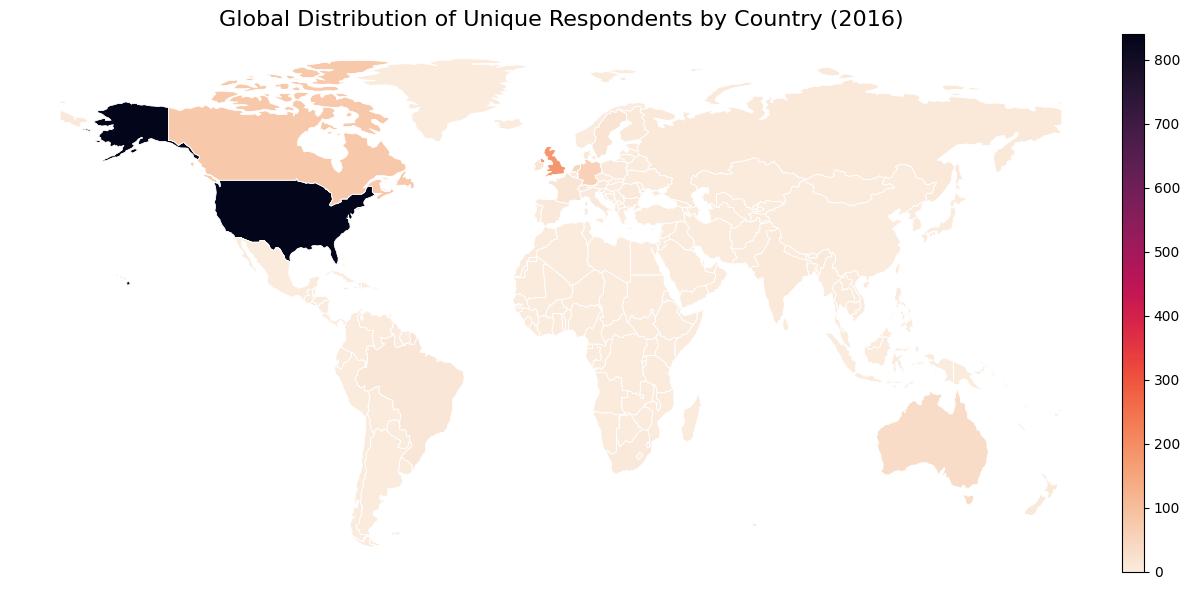

                     Country  respondent_count
0   United States Of America               840
1             United Kingdom               180
2                     Canada                78
3                    Germany                58
4                Netherlands                48
5                  Australia                35
6                     Sweden                19
7                     France                16
8                    Ireland                15
9                Switzerland                10
10                    Brazil                10
13                    Russia                 9
12                     India                 9
11               New Zealand                 9
14                  Bulgaria                 7
15                   Finland                 7
16                   Denmark                 7
17                     Italy                 5
18                   Belgium                 5
19              South Africa                 4
20           

In [46]:
shapefile_path = "ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp"

country_distribution_2016 = plot_global_country_distribution_2016(
    merged_df, shapefile_path
)

print(country_distribution_2016)

World map graph shows that the survey participants were mainly from US, with small of participants being from UK, Germany, Australia and Canada as well.

1. United States - The overwhelming majority of responses came from the U.S., likely due to survey reach, language accessibility, and industry concentration.

2. United Kingdom - A significant number of responses suggest strong awareness or outreach efforts in English-speaking countries.

3. Canada & Germany - These countries show moderate participation, possibly reflecting their tech industry engagement.

Low-Participation Countries (≤0.02%) - Countries like Ethiopia, Ecuador, Brunei, Belarus, and The Bahamas have minimal engagement, possibly due to limited survey outreach or tech sector presence in these regions.

Let's take a closer look at US and it's states geographic distribution of survey respondents :

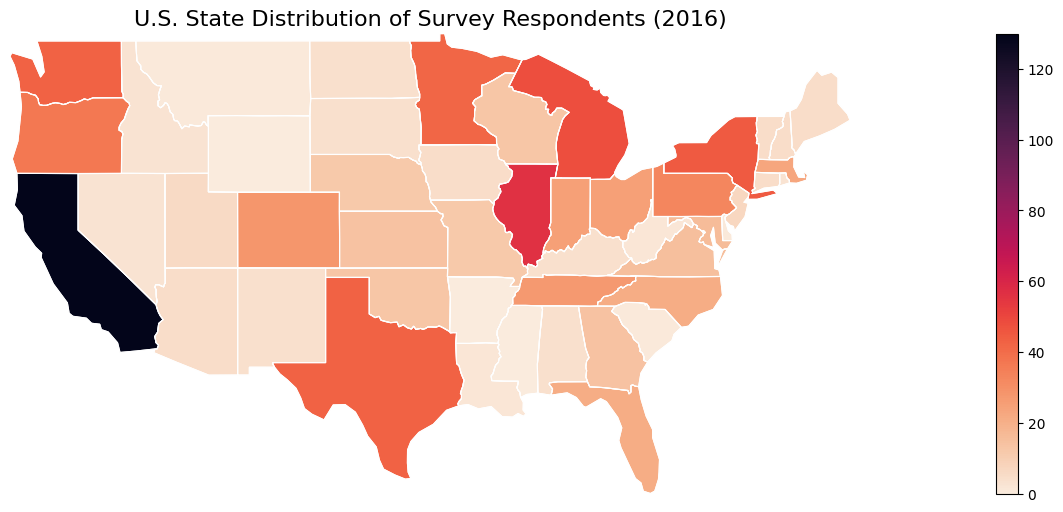

                   State  respondent_count
0             California               130
1               Illinois                56
2               Michigan                48
3               New York                45
4             Washington                43
5                  Texas                43
6              Minnesota                42
7                 Oregon                37
8           Pennsylvania                33
9               Colorado                28
10             Tennessee                27
12               Indiana                25
11                  Ohio                25
13         Massachusetts                23
14        North Carolina                21
15               Florida                21
16              Maryland                16
17              Virginia                15
18                Kansas                14
19               Georgia                14
20             Wisconsin                13
21              Oklahoma                13
23         

In [47]:
shapefile_path = "ne_110m_admin_1_states_provinces/ne_110m_admin_1_states_provinces.shp"

state_distribution_2016 = plot_us_state_distribution_map_2016(merged_df, shapefile_path)

# See the state counts
print(state_distribution_2016)

In [48]:
total_respondents = state_distribution_2016["respondent_count"].sum()

california_count = 130
percentage_california = (california_count / total_respondents) * 100

print(percentage_california)

15.476190476190476


15,47 % of all 2016 survey respondents from America are based in California.

State map is dominated by California, followed by Ilinious and Washington states. Not surprising since majority of technology companies are based in California.

Key findings :

•California leads the responses, with the highest percentage of survey participants. This aligns with its position as a major tech and corporate hub, where workplace mental health discussions are more prevalent.

•Illinois, Washington, and New York also show strong participation, reflecting high concentrations of professionals in urban areas and industries where mental health awareness is growing.

•Texas and Florida, despite having large populations, show relatively lower response rates, suggesting possible regional differences in survey outreach or awareness.

•Lower participation states (e.g., Montana, Mississippi, Delaware) make up a very small percentage of responses, likely due to lower survey visibility in these regions or differences in workplace culture.

Additional insights :

1. Higher participation in states with strong tech, finance, and corporate presence suggests that workplace mental health awareness may be more developed in these regions.

2. Lower engagement in some states could indicate gaps in awareness, industry representation, or outreach strategies.

3. Future surveys should consider targeted outreach in lower-participation states to improve geographic representation.

## Exploring relationships between locations and mental conditions

In [34]:
ranked_conditions_2016 = rank_top_20_categorized_conditions_2016(db_path)

                     Country         Category  TotalUsers  Rank
0   United States of America       Depression         289     1
1   United States of America          Anxiety         231     2
2   United States of America            Other         149     3
3   United States of America             PTSD          50     4
4             United Kingdom       Depression          45     5
5             United Kingdom          Anxiety          43     6
6   United States of America              OCD          35     7
7                     Canada          Anxiety          18     8
8   United States of America  Stress Disorder          17     9
9                     Canada       Depression          16    10
10               Netherlands            Other          14    11
11                 Australia       Depression          13    12
12            United Kingdom            Other          13    12
13               Netherlands       Depression          12    14
14  United States of America  Eating Dis

United States leads in reported cases of Depression (289 users) and Anxiety (231 users).

Other conditions ("Other" conditions include Schizophrenia, ADHD, BPD, Substance Use Disorders, Autism, and Sleep Disorders not categorized into the main groups) are the 3rd most common in the U.S., with 149 users.

PTSD reports are also significant in the U.S. (50 users), followed by OCD (35 users).

United Kingdom ranks 5th and 6th for Depression (45 users) and Anxiety (43 users), respectively.

Canada, Netherlands, and Australia also report high numbers for Anxiety and Depression.

Eating Disorders are less frequently reported, with 11 users in the U.S.

In [35]:
top_20_conditions_by_state_2016 = rank_top_20_conditions_across_states_2016(
    db_path, condition_mapping
)

           State    Category  TotalUsers  Rank
0     California  Depression          43     1
1     California     Anxiety          35     2
2     California       Other          29     3
3       Illinois  Depression          23     4
4   Pennsylvania  Depression          18     5
5       Illinois     Anxiety          18     6
6       New York  Depression          17     7
7          Texas  Depression          17     8
8         Oregon  Depression          17     9
9   Pennsylvania     Anxiety          16    10
10         Texas     Anxiety          14    11
11     Minnesota  Depression          14    12
12      New York     Anxiety          13    13
13    Washington  Depression          13    14
14     Minnesota     Anxiety          12    15
15      Michigan  Depression          12    16
16      Michigan     Anxiety          12    17
17        Oregon     Anxiety          11    18
18       Indiana  Depression          10    19
19    Washington     Anxiety          10    20


California leads with the highest counts for both Depression (43 respondents) and Anxiety (35 respondents).

Depression consistently appears as the most reported condition across several states, including Illinois, Pennsylvania, New York, Texas, and Oregon.

Anxiety follows a similar trend, frequently ranking second in many states.

Minnesota and Michigan have a relatively higher count of Anxiety responses compared to other conditions.


Results summary :

Based on this data, there’s no strong evidence of a high difference between the state you live in and the mental health condition you report.

No single state shows a unique mental health condition pattern that would suggest geography plays a significant role in what condition people have.

While the total number of respondents varies by country (for example, the U.S. has many more respondents overall), the relative distribution of conditions is similar across countries.

No country shows a unique condition trend that stands out drastically. The same categories of mental health issues are prevalent in every region represented here.

## Relationship between mental conditions and age

Frequency distribution of categorical variables (age groups and mental health conditions) :

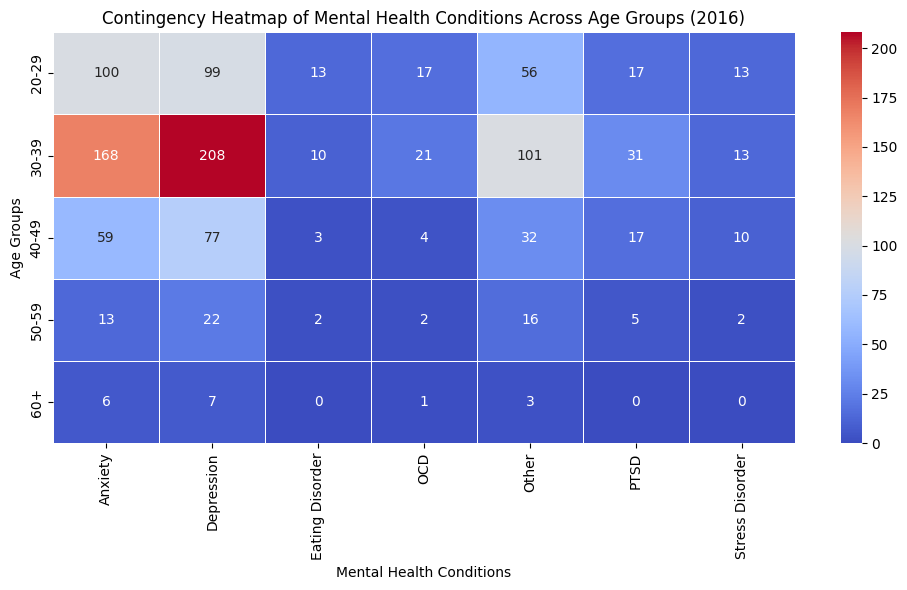

In [36]:
contingency_table = generate_age_conditions_contingency_heatmap_2016(
    db_path, merged_df, condition_mapping
)



Key observations :

- Younger respondents (20-29, 30-39) have the highest reported cases of mental health conditions.

- Anxiety and Depression are the most common conditions** across all age groups.

- PTSD and Eating Disorders are more frequent in younger age groups.

- Older age groups (50-59, 60+) report significantly fewer cases across all conditions.


Insights :

1. Depression and Anxiety show the highest prevalence across all age groups**, peaking in the 30-39 range.
2. OCD and Eating Disorders appear more frequently in younger age groups**, with numbers declining in older groups.
3. PTSD is notable in the younger demographics but drops significantly in older adults.



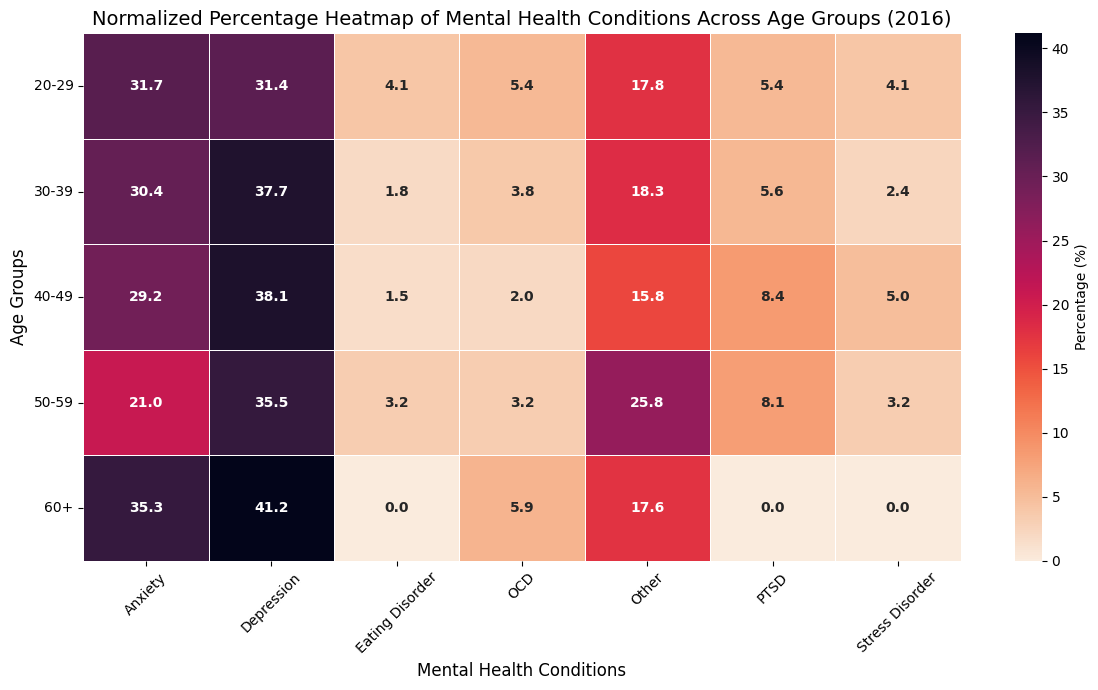

Category,Anxiety,Depression,Eating Disorder,OCD,Other,PTSD,Stress Disorder
Age Group,,,,,,,
20-29,31.746032,31.428571,4.126984,5.396825,17.777778,5.396825,4.126984
30-39,30.434783,37.681159,1.811594,3.804348,18.297101,5.615942,2.355072
40-49,29.207921,38.118812,1.485149,1.980198,15.841584,8.415842,4.950495
50-59,20.967742,35.483871,3.225806,3.225806,25.806452,8.064516,3.225806
60+,35.294118,41.176471,0.000000,5.882353,17.647059,0.000000,0.000000


In [37]:
normalized_contingency_table_2016 = generate_normalized_age_conditions_heatmap_2016(
    db_path, merged_df, condition_mapping
)

normalized_contingency_table_2016

Key insights:

Depression is the most frequently reported condition across all age groups, peaking at 41.18% in the 60+ age group.

Anxiety maintains a consistent presence, highest among 60+ respondents (35.29%) and those aged 20-29 (31.75%).

PTSD peaks in the 40-49 (8.42%) and 50-59 (8.06%) age groups.

Eating Disorders are more commonly reported in the 20-29 age group (4.13%), while they disappear in the 60+ group.

Other Conditions are most prevalent among respondents aged 50-59 (25.81%).

Results highlights :

All age groups suffers from Depression and Anxiety the most, compared to other conditions.

60+ group, even if very small in number itself, struggles  with Depression and Anxiety the most.

20-29 group has highest Eating disorder rate.

50-59 age groups deals with highest percentage of Other mental conditions, highlighting the variety of 'niche' mental conditions they deal with it.

## Deeper Analysis of Mental Conditions and Genders

I want to take a deeper dive to gender and mental conditions connections. First let's calcute, how many Men, Women and Other gender group were in 2016 survey in total :

In [38]:
gender_counts_2016 = count_unique_genders_2016(db_path)

print(gender_counts_2016)

{'Male': np.int64(1057), 'Female': np.int64(336), 'Other': np.int64(13)}


The men makes the largest part, while Other gender group have only 13 respondants. Let's see what mental conditions each of the gender group face :

In [39]:
men_conditions_2016 = count_men_conditions_2016(db_path, condition_mapping)
print("Men Conditions in 2016:", men_conditions_2016)

Men Conditions in 2016: {'Anxiety': 214, 'Depression': 243, 'OCD': 28, 'PTSD': 36, 'Eating Disorder': 10, 'Stress Disorder': 27, 'Other': 138}


In [40]:
women_conditions_2016 = count_women_conditions_2016(db_path, condition_mapping)
print("Women Conditions in 2016:", women_conditions_2016)

Women Conditions in 2016: {'Anxiety': 115, 'Depression': 146, 'OCD': 12, 'PTSD': 28, 'Eating Disorder': 16, 'Stress Disorder': 7, 'Other': 59}


In [41]:
other_gender_conditions_2016 = count_other_gender_conditions_2016(
    db_path, condition_mapping
)
print("Other Gender Conditions in 2016:", other_gender_conditions_2016)

Other Gender Conditions in 2016: {'Anxiety': 7, 'Depression': 9, 'OCD': 1, 'PTSD': 1, 'Eating Disorder': 1, 'Stress Disorder': 2, 'Other': 2}


Let's visualize data in the multibar graph :

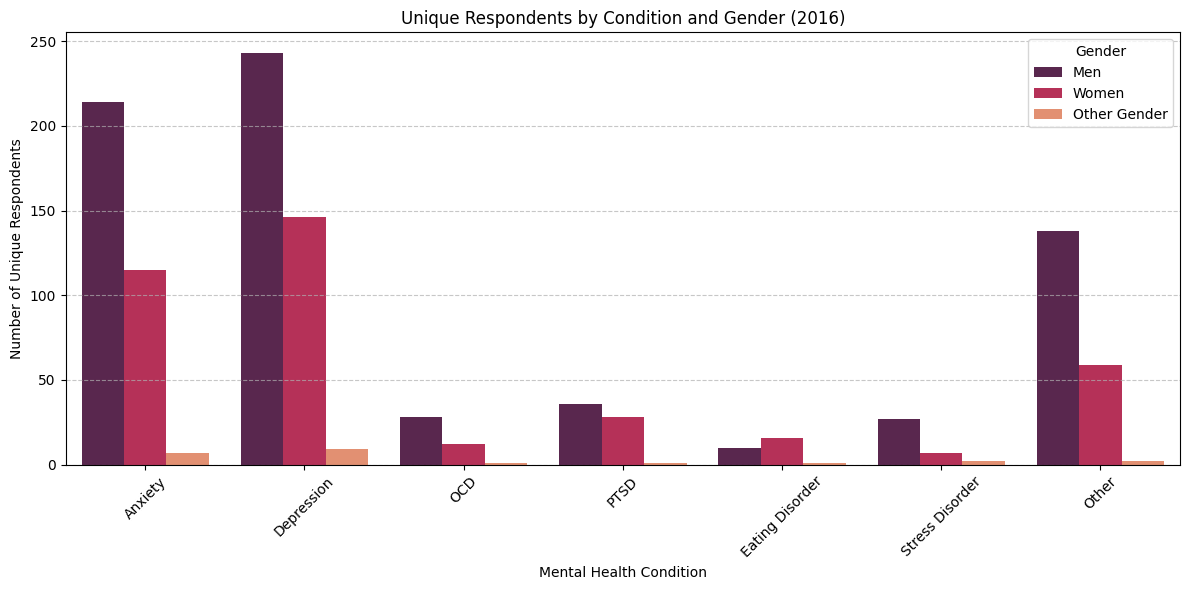

In [42]:
men_conditions_2016 = count_men_conditions_2016(db_path, condition_mapping)
women_conditions_2016 = count_women_conditions_2016(db_path, condition_mapping)
other_gender_conditions_2016 = count_other_gender_conditions_2016(
    db_path, condition_mapping
)

plot_multibar_conditions_2016(
    men_conditions_2016, women_conditions_2016, other_gender_conditions_2016
)

The results indicates that men suffers from all mental conditions (except eating disorder), but we need to keep in mind that there most men respondants overall. We need to normalize results to see the clearer picture :

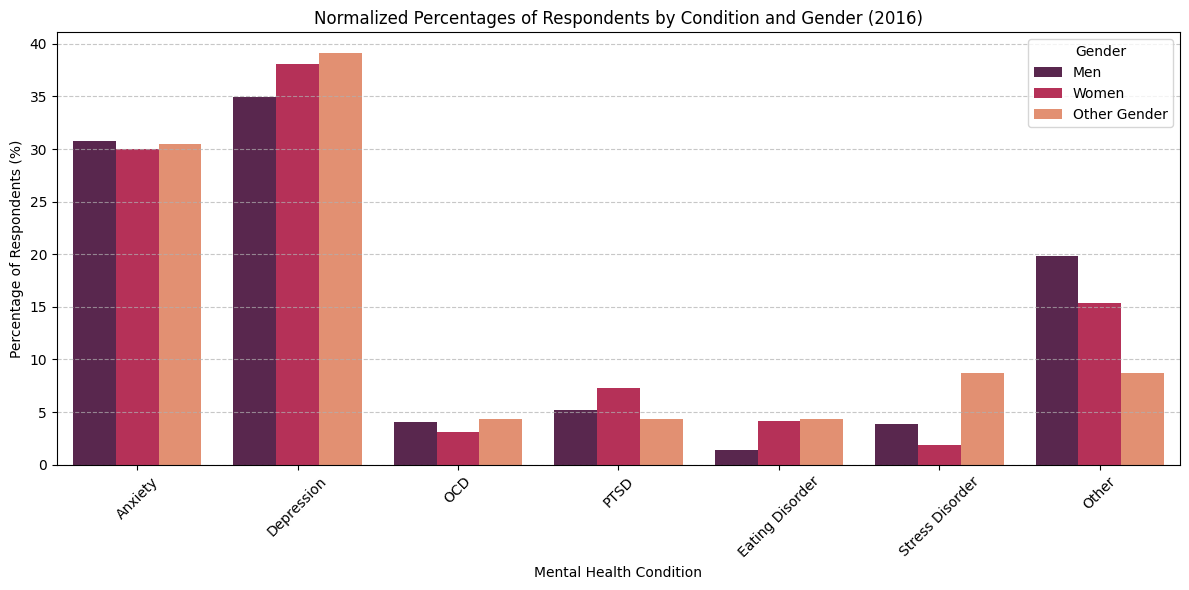


Normalized Percentages by Condition and Gender (2016):

Men:
  Anxiety: 30.75%
  Depression: 34.91%
  OCD: 4.02%
  PTSD: 5.17%
  Eating Disorder: 1.44%
  Stress Disorder: 3.88%
  Other: 19.83%

Women:
  Anxiety: 30.03%
  Depression: 38.12%
  OCD: 3.13%
  PTSD: 7.31%
  Eating Disorder: 4.18%
  Stress Disorder: 1.83%
  Other: 15.40%

Other Gender:
  Anxiety: 30.43%
  Depression: 39.13%
  OCD: 4.35%
  PTSD: 4.35%
  Eating Disorder: 4.35%
  Stress Disorder: 8.70%
  Other: 8.70%



In [43]:
plot_multibar_conditions_percentage_2016(
    men_conditions_2016, women_conditions_2016, other_gender_conditions_2016
)

Key findings and summary of results :

Women in the technology sector exhibit the highest percentage of PTSD among all groups. Additionally, they are significantly more likely than men to report Eating Disorders. Women are 1.6 times more likely to report an Eating Disorder compared to men, they also report PTSD 1.41 times more often than men

Men in the technology sector report the highest percentages of Depression and Anxiety. They also experience a highest share of Other mental health conditions, highlighting a broader range of challenges beyond the most commonly reported diagnoses. Men  are 1.29 times more likely to report "Other" mental health conditions compared to women (19.83% vs. 15.40%), and nearly 2.3 times more likely than Other Gender respondents (19.83% vs. 8.70%). These "Other" conditions often include less commonly reported or unspecified issues such as substance use disorders, sleep disorders, and mood disturbances not classified under Depression or Anxiety.

Respondents of Other gender (non- binary f.e.) show a more evenly distributed prevalence across mental health conditions. While Depression and Anxiety remain the most commonly reported, they also experience notably higher proportions of Stress Disorders and Eating Disorders compared to men and women. Almost 40% of Other gender respondants reported Depression which are the highest percentage of mental condition in any gender group.

Across all gender groups in the technology sector, Anxiety and Depression are the most commonly reported mental health conditions. 

## Analysis Conclusion

What percentage of individuals working in the technology sector experience mental health issues? A percentage 65.7% of individuals working in the technology sector report experiencing mental health issues.

What are the most common mental conditions? The most common mental health conditions reported are Depression and Anxiety by far. Followed by Other (group of less popular mental conditions) conditions, stress-related disorders, PTSD and OCD.

Which age groups are most prone to being diagnosed with such conditions? Middle age groups, particularly those between 30-39, are most prone to being diagnosed with mental health conditions, especially anxiety and depression in total. But on average 60+ are the most vulnerable groups, especially for depression 41.2%. It's worth mentioning sample of this group is very small, so results might be not fully trustworthy.

Is there a link between location (country, state) and the mental conditions reported? Not a single country or US state shows a unique mental health condition pattern that would suggest geography plays a significant role in what condition people have.

How do mental health conditions vary across different gender groups, and which conditions are most commonly reported by each gender? In total, men reported the highest overall number of cases. However, when normalized, it’s evident that all gender groups experience mental health challenges. Anxiety and Depression are the most commonly reported conditions across all groups. Men are 1.29 times more likely to report "Other" mental health conditions (less common disorders) compared to women. The Other gender group (those who don't identify within the traditional  categories) shows higher rates of Stress Disorders and Eating Disorders compared to both men and women. Women are 1.6 times more likely to report Eating Disorders than men and report PTSD 1.41 times more often than men.

48.6% of all respondents in the 2016 survey reported Depression as one of their conditions.

39.3% of all respondents in the 2016 survey reported Anxiety as one of their condition.

## Thoughts On How This Analysis Could Be Better

Possible ways to improve this analysis :

Expanding scope beyond 2016, larger time line of analysis could provide more accurate and different results. Good chunk of my analysis of mental conditions are based on one question. Since that question was only asked in 2016 survey, it limited majority of my project to be based on only 2016 data, disregarding all other years information. It would be better to base my analysis on more questions and compare data changes through years. Focusing on 2016 answers also made by sample size much smaller, yet less reliable.

Improved data categorization. It would enhance the accuracy of the analysis. In my study, there were two "Other" groups: one for gender identities outside the traditional male/female categories and another for less common mental conditions. Further exploring and refining the categorization of these groups could provide a clearer understanding of these populations and improve the overall precision of the analysis.

Cross-referencing with external Studies. Comparing my findings with external research or literature could help validate my analysis and provide a broader context for results and conclusions.

Incorporating Statistical Significance. Integrate statistical tests (e.g., chi-square, t-tests) to determine if the differences between groups (e.g., gender, age,) are statistically significant. This would strengthen the reliability of my findings.